##Get the dependency tags for shortlisted sentences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install praw

     |████████████████████████████████| 176 kB 5.0 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 


In [ ]:
import spacy
import pandas as pd
import tqdm
import praw

In [ ]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


Relation Extraction

In [ ]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


Build the knoledge graph

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/CP Sem-8/Dataset(s)/Reddit/FreeCompliments/subs_FreeCompliments_2020.csv")
print(data.shape)
print(data.columns)

(27443, 10)
Index(['post_id', 'title', 'url', 'author', 'score', 'publish_date',
       'num_comms', 'Permalink', 'Flair', 'text'],
      dtype='object')


## Extracting comments

In [ ]:
#Reddit stuff
reddit=praw.Reddit(
    client_id ="v2DtapNsjab-CDh00ctXLA",
    client_secret="ifrq3aOgBk01t9wMbJgO72TcrcvV8A",
    password="Maa@g110",
    user_agent="test script by r/unpopularopinion",
    username="sinhasagar507",
)

#Verifying connection
print(reddit.user.me())

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



sinhasagar507


In [ ]:
# Reply extraction - Comment it out once IA over - we will have the graphs made from json files?
"""
sub = reddit.submission("ejqumk")
text = []
sub.comments.replace_more(limit=None)
comment_queue = sub.comments[:]  # Seed with top-level
while comment_queue:
    comment = comment_queue.pop(0)
    print(comment.body)
    text.append(comment.body)
    comment_queue.extend(comment.replies)
"""

In [ ]:
# {"ejqumk": ("My name is Sagar Sinha", [])}

['I don’t agree but i usually try to keep some water bottles and some snacks on me to give to them. A few of them got pissed off and demanded money making me believe they’re either scammers or trying to get money for drugs',
 'Or buy them food. I’ve bought meals/groceries for people on the streets before, at least I know I helped them with a need not an addiction.',
 'No.\n\n\n\n\n\n\nAnd I’m editing my comment to tell a story.\n\n\nEating lunch one day at McDonald’s (because at the time I had to work 45-50 hours a week depending on my workload and had to grab a quick bite), had a homie come up to me asking to buy him a burger. I agree, get him not 1, but 2 burgers.  He looks at me, looks at the register lady, looks as me again and says: “I don’t want that, I wanted the Big Mac meal”. I told him I don’t even treat myself daily with that, now, $8+ fast food meal. \n\nShould’ve took the burgers and stomped them out on the floor. Besides that guy, everyone on the street apparently doesn’t

In [ ]:
# Doing random sampling to select some random sentences
dataList = data['title'].to_list() 

In [ ]:
# Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


Chunked Code:

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
print(get_entities("I love to eat and drink"))

['I', '']


In [ ]:
len(text)

50

In [ ]:
entity_pairs=[]

for sent in text:
  entity_pairs.append(get_entities(sent))

In [ ]:
entity_pairs

[['they', 'drugs'],
 ['I', 'need'],
 ['’ve food everyone', 'only  money'],
 ['when  I', 'soft pizza it'],
 ['', 'them'],
 ['local indigent homeless', 'drug testing'],
 ['You', 'human  tragedy'],
 ['out  they', 'rather  all'],
 ['hard  they', 'it'],
 ['big  They', '$  100,000'],
 ['I', 'that'],
 ['how  posts', 'judgmental  people'],
 ['better  they', 'bit'],
 ['24 hrs It', '24 hrs time'],
 ['who', 'there  sign'],
 ['other emergency I', 'kind  you'],
 ['times  I', 'intolerant  earth'],
 ['attitude', 'kindness'],
 ['just  you', 'position'],
 ['They', 'food'],
 ['I', 'tragedy'],
 ['Being', 'heroin'],
 ['real  altruism', 'real  ass'],
 ['where  everyone', 'other'],
 ['I', 'longer  it'],
 ['perfect  being', 'really  help'],
 ['', ''],
 ['maybe  they', 'free  coffee'],
 ['That', 'how  loser'],
 ['why  I', 'rather  way'],
 ['It', 'good  anyone'],
 ['few drug dealing They', 'prison'],
 ['heavy shit who', 'away  heroine'],
 ['then  I', 'them'],
 ['', ''],
 ['all  statement', 'me'],
 ['drugs  The

In [ ]:
# Understand this piece of code and how one can generate predicates from it
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(sent) for sent in text]

In [ ]:
pd.Series(relations).value_counts()[:50]

is                   4
’s                   2
's                   2
want                 2
apologies            2
deleted              2
help                 1
telling              1
belong in            1
sympathy             1
seem unfair          1
freak                1
pissed               1
feel                 1
Deleted              1
be impossible        1
are                  1
take more            1
took                 1
admit                1
act                  1
hop                  1
sounds like          1
tend                 1
give                 1
ask for              1
turn                 1
volunteer            1
encouraging human    1
stay homeless        1
given                1
made                 1
like                 1
helped               1
do                   1
giving               1
Thank                1
Scum of              1
exists               1
hope                 1
sure                 1
Keep                 1
dtype: int64

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
kg_df

,source,target,edge
0,they,drugs,pissed
1,I,need,helped
2,’ve food everyone,only money,ask for
3,when I,soft pizza it,turn
4,,them,volunteer
5,local indigent homeless,drug testing,is
6,You,human tragedy,encouraging human
7,out they,rather all,stay homeless
8,hard they,it,given
9,big They,"$ 100,000",made


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

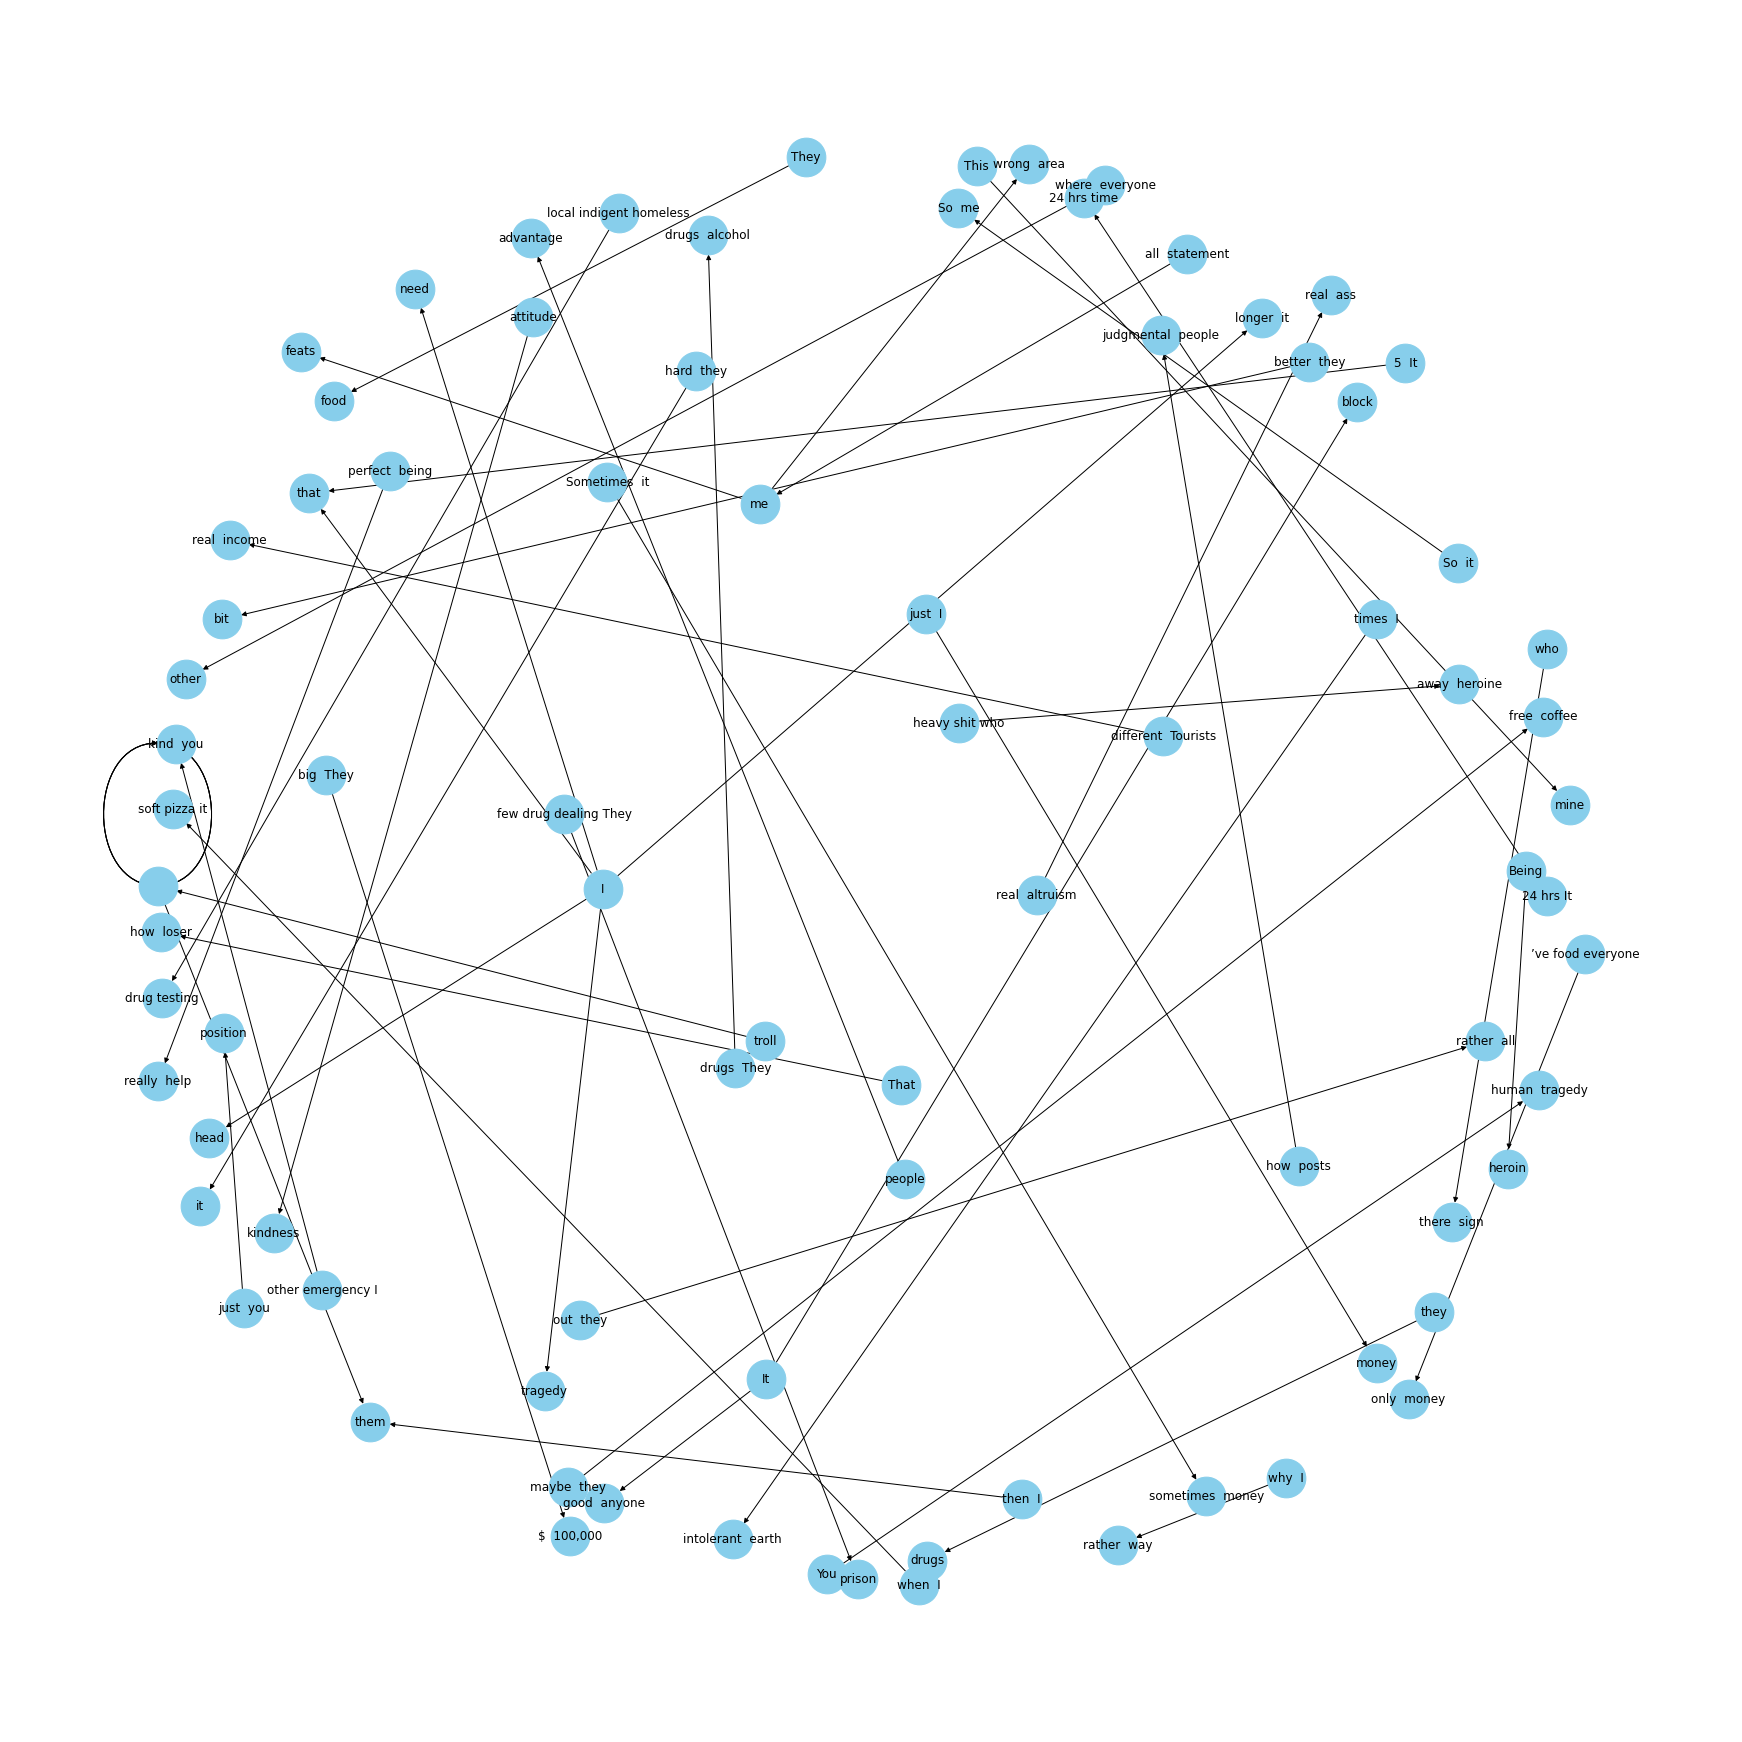

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(24, 24))
pos = nx.spring_layout(G, k = 1) #k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()